In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel



sns.set_theme()


SHAPE (rows, cols): (36285, 17)

COLUMNS:
 ['Booking_ID', 'number of adults', 'number of children', 'number of weekend nights', 'number of week nights', 'type of meal', 'car parking space', 'room type', 'lead time', 'market segment type', 'repeated', 'P-C', 'P-not-C', 'average price', 'special requests', 'date of reservation', 'booking status']


,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled


,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
36238,INN36239,1,0,0,1,Not Selected,0,Room_Type 1,117,Online,0,0,0,161.10,1,11/10/2018,Canceled
83,INN00084,2,0,1,4,Meal Plan 1,0,Room_Type 4,40,Online,0,0,0,98.82,0,3/14/2018,Not_Canceled
23449,INN23450,1,0,0,1,Meal Plan 1,1,Room_Type 1,7,Corporate,1,0,7,98.00,1,6/22/2018,Not_Canceled
14981,INN14982,1,0,2,1,Meal Plan 1,0,Room_Type 1,116,Online,0,0,0,1.00,0,2/28/2018,Not_Canceled
18392,INN18393,2,0,1,0,Meal Plan 1,0,Room_Type 1,141,Offline,0,0,0,90.00,0,9/20/2017,Not_Canceled



INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36285 entries, 0 to 36284
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Booking_ID                36285 non-null  object 
 1   number of adults          36285 non-null  int64  
 2   number of children        36285 non-null  int64  
 3   number of weekend nights  36285 non-null  int64  
 4   number of week nights     36285 non-null  int64  
 5   type of meal              36285 non-null  object 
 6   car parking space         36285 non-null  int64  
 7   room type                 36285 non-null  object 
 8   lead time                 36285 non-null  int64  
 9   market segment type       36285 non-null  object 
 10  repeated                  36285 non-null  int64  
 11  P-C                       36285 non-null  int64  
 12  P-not-C                   36285 non-null  int64  
 13  average price             36285 non-null  float64
 14 

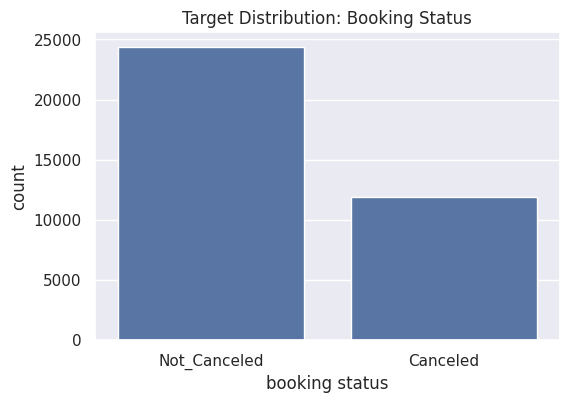

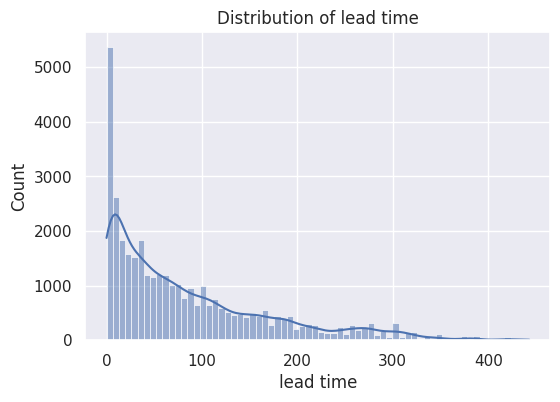

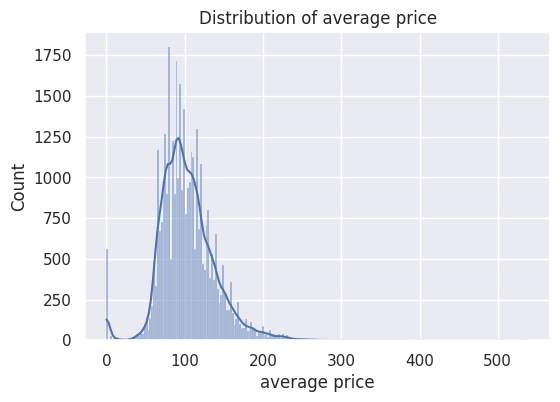

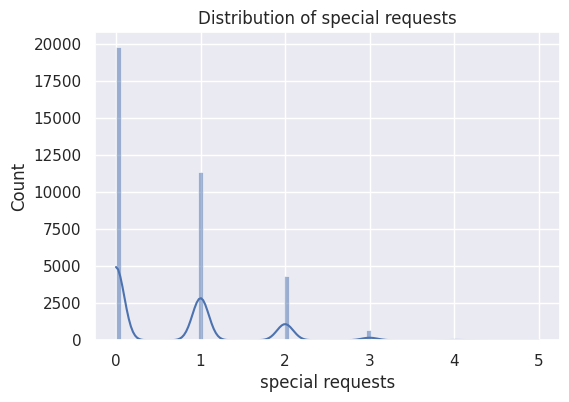

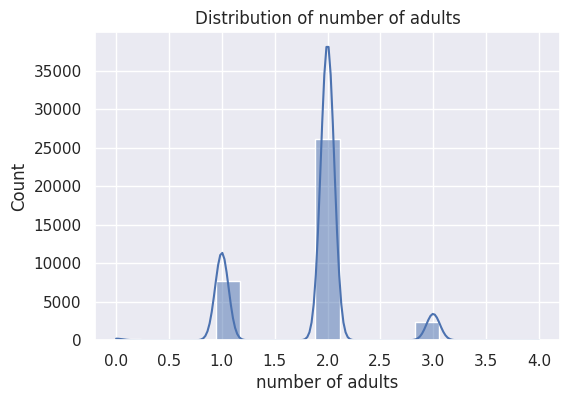

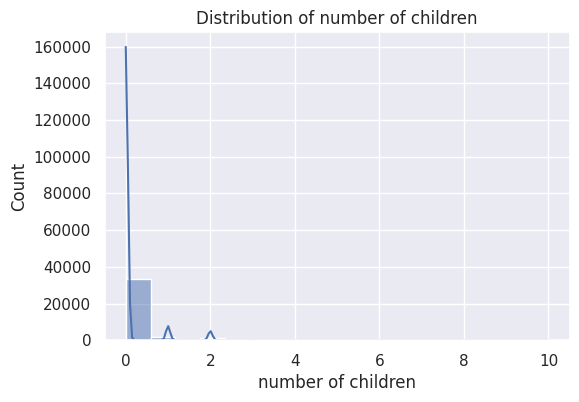

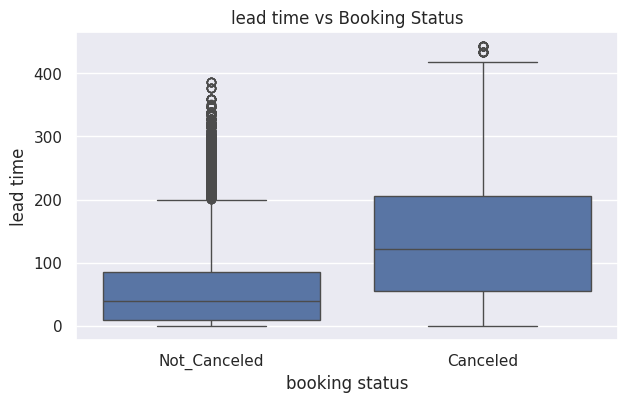

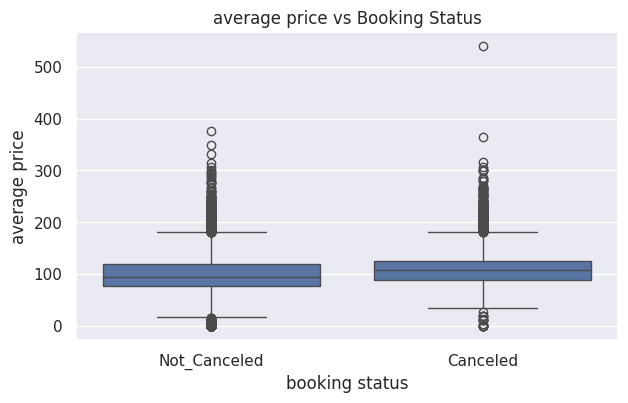

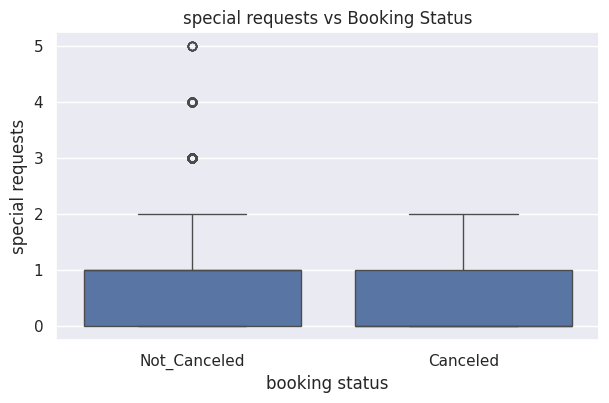

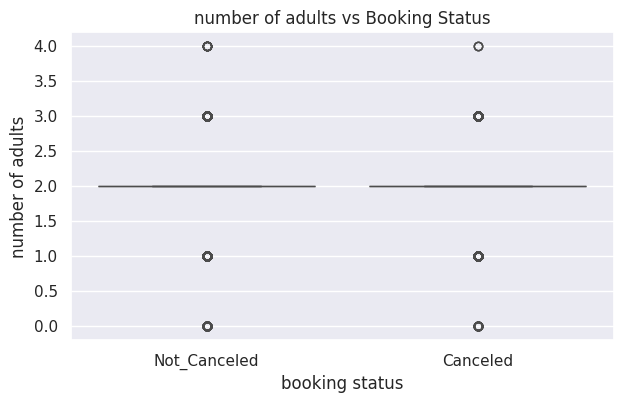

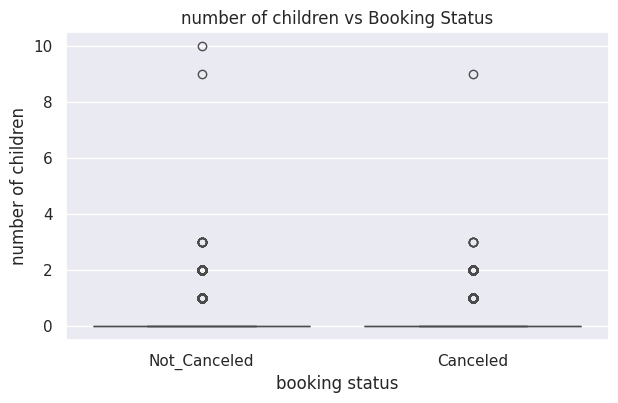

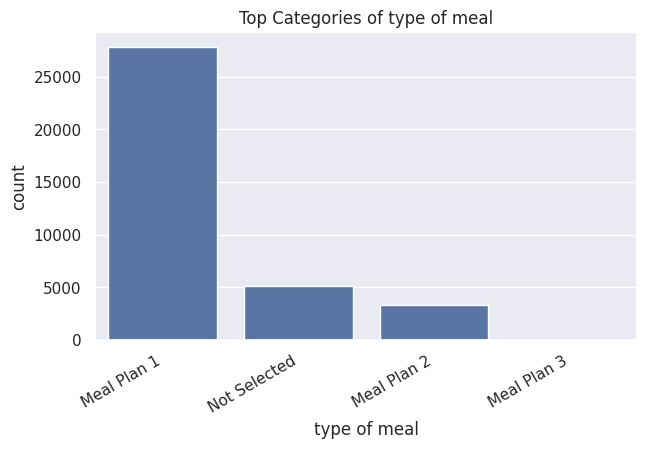

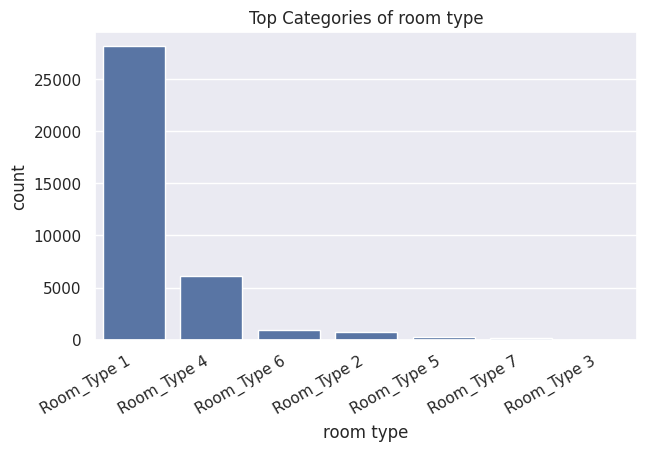

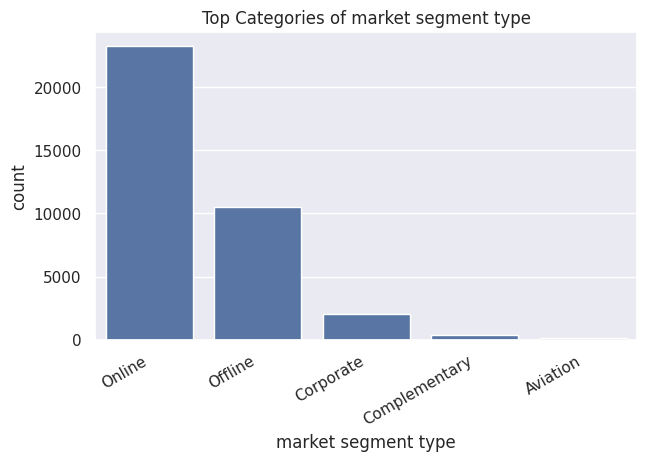

In [ ]:
# TASK 1: EDA + DATA UNDERSTANDING + BASIC CLEANING

df = pd.read_csv("booking.csv")

print("SHAPE (rows, cols):", df.shape)
print("\nCOLUMNS:\n", df.columns.tolist())

# 1B) PREVIEW
display(df.head())
display(df.sample(5, random_state=42))

# 1C) INFO + MISSING + DUPLICATES
print("\nINFO:")
df.info()

print("\nMISSING VALUES (per column):")
print(df.isna().sum())

print("\nDUPLICATE ROWS:", df.duplicated().sum())

# 1D) TARGET CHECK
target_col = "booking status"
print("\nTARGET VALUE COUNTS:")
print(df[target_col].value_counts())
print("\nTARGET PROPORTION:")
print(df[target_col].value_counts(normalize=True))

# 1E) DATE FEATURE ENGINEERING
date_col = "date of reservation"
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

df["res_year"] = df[date_col].dt.year
df["res_month"] = df[date_col].dt.month
df["res_day"] = df[date_col].dt.day
df["res_dayofweek"] = df[date_col].dt.dayofweek

# 1F) DROP ID + ORIGINAL DATE
drop_cols = ["Booking_ID", date_col]
df_model = df.drop(columns=drop_cols)

# 1G) EDA VISUALS (KEEP THESE)
plt.figure(figsize=(6,4))
sns.countplot(x=target_col, data=df_model)
plt.title("Target Distribution: Booking Status")
plt.show()

key_nums = ["lead time", "average price", "special requests", "number of adults", "number of children"]
key_nums = [c for c in key_nums if c in df_model.columns]

for c in key_nums:
    plt.figure(figsize=(6,4))
    sns.histplot(df_model[c], kde=True)
    plt.title(f"Distribution of {c}")
    plt.show()

for c in key_nums:
    plt.figure(figsize=(7,4))
    sns.boxplot(x=target_col, y=c, data=df_model)
    plt.title(f"{c} vs Booking Status")
    plt.show()

cat_cols_tmp = df_model.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
cat_cols_tmp = [c for c in cat_cols_tmp if c != target_col]

for c in cat_cols_tmp:
    plt.figure(figsize=(7,4))
    order = df_model[c].value_counts().index[:10]
    sns.countplot(data=df_model, x=c, order=order)
    plt.title(f"Top Categories of {c}")
    plt.xticks(rotation=30, ha="right")
    plt.show()




TARGET COLUMN USED: booking status
TARGET VALUE COUNTS (0/1):
booking status
0    24396
1    11889
Name: count, dtype: int64

NUMERICAL FEATURES: 15
CATEGORICAL FEATURES: 3

Neural Network (MLP) - TRAIN METRICS
Accuracy : 0.8722268154884939
Precision: 0.828986164663189
Recall   : 0.7685837451372095
F1-Score : 0.7976430792732828

Neural Network (MLP) - TEST METRICS
Accuracy : 0.8641311836847182
Precision: 0.8163636363636364
Recall   : 0.7552565180824222
F1-Score : 0.7846221057230232

Classification Report (TEST):
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      4879
           1       0.82      0.76      0.78      2378

    accuracy                           0.86      7257
   macro avg       0.85      0.84      0.84      7257
weighted avg       0.86      0.86      0.86      7257



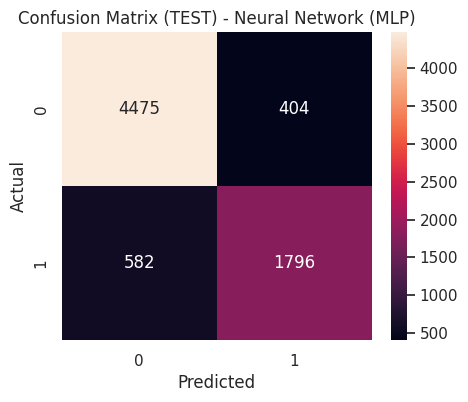

TASK 2 COMPLETED


In [ ]:
# TASK 2: NEURAL NETWORK MODEL (MLP)

from sklearn.impute import SimpleImputer

# Helper to find columns safely (ignores case/spaces)
def find_col(df_cols, wanted):
    wanted_norm = wanted.strip().lower().replace("_", " ")
    for c in df_cols:
        c_norm = c.strip().lower().replace("_", " ")
        if c_norm == wanted_norm:
            return c
    return None

# 2A) TARGET COLUMN
target_col = find_col(df_model.columns, "booking status")
if target_col is None:
    raise ValueError("Cannot find target column similar to 'booking status'. Check your CSV column name.")

# 2B) BUILD X / y
X = df_model.drop(columns=[target_col]).copy()
y_raw = df_model[target_col].copy()

# 2C) MAKE TARGET BINARY
if y_raw.dtype == "object":
    y_str = y_raw.astype(str).str.strip().str.lower()
    if y_str.isin(["canceled", "cancelled", "1", "yes", "true"]).any():
        y = y_str.isin(["canceled", "cancelled", "1", "yes", "true"]).astype(int)
    else:
        top = y_str.value_counts().index[0]
        y = (y_str != top).astype(int)
else:
    y = y_raw.astype(int)

print("TARGET COLUMN USED:", target_col)
print("TARGET VALUE COUNTS (0/1):")
print(pd.Series(y).value_counts())

# 2D) COLUMN TYPES
categorical_features = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
numerical_features = X.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns.tolist()

print("\nNUMERICAL FEATURES:", len(numerical_features))
print("CATEGORICAL FEATURES:", len(categorical_features))

# 2E) PREPROCESS (IMPUTE FIRST - THEN SCALE/OHE)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

# 2F) TRAIN/TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 2G) MODEL PIPELINE
mlp_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        alpha=0.0005,
        max_iter=400,
        random_state=42,
        early_stopping=True,
        n_iter_no_change=10
    ))
])

mlp_clf.fit(X_train, y_train)

# 2H) EVALUATION FUNCTION
def eval_classification(model, X_tr, y_tr, X_te, y_te, name="MODEL"):
    yhat_tr = model.predict(X_tr)
    yhat_te = model.predict(X_te)

    print("\n==============================")
    print(f"{name} - TRAIN METRICS")
    print("==============================")
    print("Accuracy :", accuracy_score(y_tr, yhat_tr))
    print("Precision:", precision_score(y_tr, yhat_tr, zero_division=0))
    print("Recall   :", recall_score(y_tr, yhat_tr, zero_division=0))
    print("F1-Score :", f1_score(y_tr, yhat_tr, zero_division=0))

    print("\n==============================")
    print(f"{name} - TEST METRICS")
    print("==============================")
    print("Accuracy :", accuracy_score(y_te, yhat_te))
    print("Precision:", precision_score(y_te, yhat_te, zero_division=0))
    print("Recall   :", recall_score(y_te, yhat_te, zero_division=0))
    print("F1-Score :", f1_score(y_te, yhat_te, zero_division=0))

    print("\nClassification Report (TEST):")
    print(classification_report(y_te, yhat_te, zero_division=0))

    cm = confusion_matrix(y_te, yhat_te)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f"Confusion Matrix (TEST) - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

eval_classification(mlp_clf, X_train, y_train, X_test, y_test, name="Neural Network (MLP)")

print("TASK 2 COMPLETED")



Logistic Regression (Baseline) - TRAIN METRICS
Accuracy : 0.8036723163841808
Precision: 0.7349026374168105
Recall   : 0.6269582588581643
F1-Score : 0.6766524822695036

Logistic Regression (Baseline) - TEST METRICS
Accuracy : 0.8130081300813008
Precision: 0.7556334501752628
Recall   : 0.6345668629100084
F1-Score : 0.6898285714285715

Classification Report (TEST):
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      4879
           1       0.76      0.63      0.69      2378

    accuracy                           0.81      7257
   macro avg       0.80      0.77      0.78      7257
weighted avg       0.81      0.81      0.81      7257



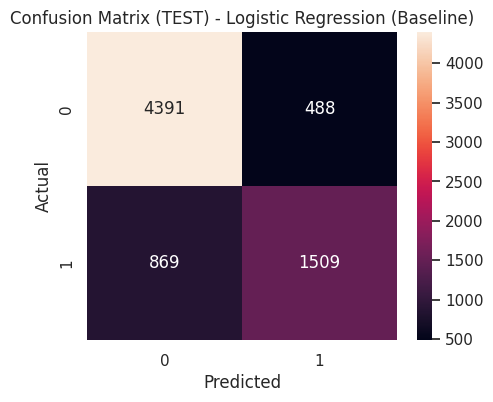


Random Forest (Baseline) - TRAIN METRICS
Accuracy : 0.9942469339947637
Precision: 0.9936601859678783
Recall   : 0.988749868573231
F1-Score : 0.9911989459815547

Random Forest (Baseline) - TEST METRICS
Accuracy : 0.9069863579991733
Precision: 0.8947612424663886
Recall   : 0.8116063919259883
F1-Score : 0.8511576626240352

Classification Report (TEST):
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      4879
           1       0.89      0.81      0.85      2378

    accuracy                           0.91      7257
   macro avg       0.90      0.88      0.89      7257
weighted avg       0.91      0.91      0.91      7257



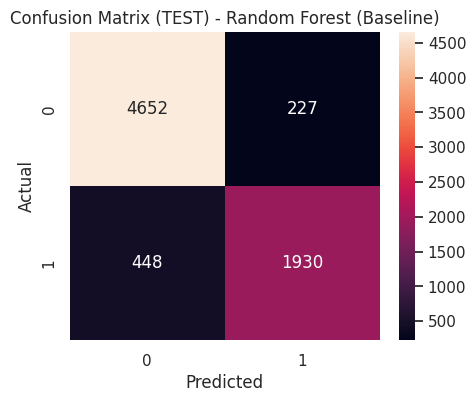

TASK 3 COMPLETED


In [ ]:
# TASK 3: PRIMARY MODELS (LOGREG + RANDOM FOREST) - NaN SAFE

logreg_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=3000, random_state=42))
])

rf_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(random_state=42))
])

logreg_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)

eval_classification(logreg_pipe, X_train, y_train, X_test, y_test, name="Logistic Regression (Baseline)")
eval_classification(rf_pipe, X_train, y_train, X_test, y_test, name="Random Forest (Baseline)")

print("TASK 3 COMPLETED")


In [ ]:
# TASK 4: HYPERPARAMETER OPTIMIZATION (GRIDSEARCHCV)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

logreg_params = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__solver": ["lbfgs"]
}

logreg_grid = GridSearchCV(
    estimator=logreg_pipe,
    param_grid=logreg_params,
    scoring="f1",
    cv=cv,
    n_jobs=-1
)
logreg_grid.fit(X_train, y_train)

print("BEST LOGREG PARAMS:", logreg_grid.best_params_)
print("BEST LOGREG CV F1 :", logreg_grid.best_score_)

rf_params = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2]
}

rf_grid = GridSearchCV(
    estimator=rf_pipe,
    param_grid=rf_params,
    scoring="f1",
    cv=cv,
    n_jobs=-1
)
rf_grid.fit(X_train, y_train)

print("BEST RF PARAMS:", rf_grid.best_params_)
print("BEST RF CV F1 :", rf_grid.best_score_)

print("TASK 4 COMPLETED")


BEST LOGREG PARAMS: {'model__C': 1, 'model__solver': 'lbfgs'}
BEST LOGREG CV F1 : 0.6753195733626003
BEST RF PARAMS: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 400}
BEST RF CV F1 : 0.8401532573742445
TASK 4 COMPLETED


In [ ]:
# TASK 5: FEATURE SELECTION (EMBEDDED)

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


best_logreg_C = logreg_grid.best_params_["model__C"]

rf_best = {k.replace("model__", ""): v for k, v in rf_grid.best_params_.items()}

print("Best Logistic Regression C from Task 4:", best_logreg_C)
print("Best Random Forest params from Task 4:", rf_best)


logreg_fs_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("select", SelectFromModel(
        LogisticRegression(
            penalty="l1",
            solver="liblinear",
            C=best_logreg_C,
            max_iter=3000,
            random_state=42
        ),
        threshold="median"   # selects roughly top 50% based on absolute coefficients
    )),
    ("model", LogisticRegression(
        C=best_logreg_C,
        max_iter=3000,
        random_state=42
    ))
])

# 3) BUILD RANDOM FOREST + FEATURE SELECTION PIPELINE
rf_fs_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("select", SelectFromModel(
        RandomForestClassifier(
            n_estimators=rf_best.get("n_estimators", 400),
            max_depth=rf_best.get("max_depth", None),
            min_samples_split=rf_best.get("min_samples_split", 2),
            min_samples_leaf=rf_best.get("min_samples_leaf", 1),
            random_state=42,
            n_jobs=-1
        ),
        threshold="median"   # selects roughly top 50% important features
    )),
    ("model", RandomForestClassifier(
        n_estimators=rf_best.get("n_estimators", 400),
        max_depth=rf_best.get("max_depth", None),
        min_samples_split=rf_best.get("min_samples_split", 2),
        min_samples_leaf=rf_best.get("min_samples_leaf", 1),
        random_state=42,
        n_jobs=-1
    ))
])

# 4) FIT BOTH PIPELINES
logreg_fs_pipe.fit(X_train, y_train)
rf_fs_pipe.fit(X_train, y_train)

print("\nPipelines fitted successfully (Feature Selection applied).")

# 5) PRINT SELECTED FEATURES
feature_names = logreg_fs_pipe.named_steps["preprocess"].get_feature_names_out()

# Logistic Regression selected mask + list
logreg_mask = logreg_fs_pipe.named_steps["select"].get_support()
logreg_selected = feature_names[logreg_mask]

print("\n------------------------------")
print("LOGISTIC REGRESSION FEATURE SELECTION")
print("------------------------------")
print("Selected Features:", len(logreg_selected), "/", len(feature_names))
print("Selected Feature Names (first 40):")
print(logreg_selected[:40])

# Random Forest selected mask + list
rf_mask = rf_fs_pipe.named_steps["select"].get_support()
rf_selected = feature_names[rf_mask]

print("\n------------------------------")
print("RANDOM FOREST FEATURE SELECTION")
print("------------------------------")
print("Selected Features:", len(rf_selected), "/", len(feature_names))
print("Selected Feature Names (first 40):")
print(rf_selected[:40])

# 6) TOP 20 RF IMPORTANCES
rf_selector_model = rf_fs_pipe.named_steps["select"].estimator_
rf_importances = rf_selector_model.feature_importances_

top_idx = np.argsort(rf_importances)[::-1][:20]

top_rf_table = pd.DataFrame({
    "Feature": feature_names[top_idx],
    "Importance": rf_importances[top_idx]
}).reset_index(drop=True)

print("\n------------------------------")
print("TOP 20 RANDOM FOREST IMPORTANT FEATURES (BEFORE THRESHOLD)")
print("------------------------------")
print(top_rf_table)



Best Logistic Regression C from Task 4: 1
Best Random Forest params from Task 4: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}

Pipelines fitted successfully (Feature Selection applied).

------------------------------
LOGISTIC REGRESSION FEATURE SELECTION
------------------------------
Selected Features: 16 / 31
Selected Feature Names (first 40):
['num__car parking space' 'num__lead time' 'num__repeated' 'num__P-not-C'
 'num__average price' 'num__special requests' 'num__res_year'
 'cat__type of meal_Meal Plan 1' 'cat__room type_Room_Type 1'
 'cat__room type_Room_Type 5' 'cat__room type_Room_Type 6'
 'cat__room type_Room_Type 7' 'cat__market segment type_Aviation'
 'cat__market segment type_Complementary'
 'cat__market segment type_Corporate' 'cat__market segment type_Offline']

------------------------------
RANDOM FOREST FEATURE SELECTION
------------------------------
Selected Features: 16 / 31
Selected Feature Names (first 40):
['num__numbe


FINAL - Logistic Regression (Tuned+FS) - TRAIN METRICS
Accuracy : 0.8054292407330853
Precision: 0.7421336341983201
Recall   : 0.6224371780044159
F1-Score : 0.6770356816102471

FINAL - Logistic Regression (Tuned+FS) - TEST METRICS
Accuracy : 0.8130081300813008
Precision: 0.7595322826639552
Recall   : 0.6282590412111018
F1-Score : 0.687686996547756

Classification Report (TEST):
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      4879
           1       0.76      0.63      0.69      2378

    accuracy                           0.81      7257
   macro avg       0.80      0.77      0.78      7257
weighted avg       0.81      0.81      0.81      7257



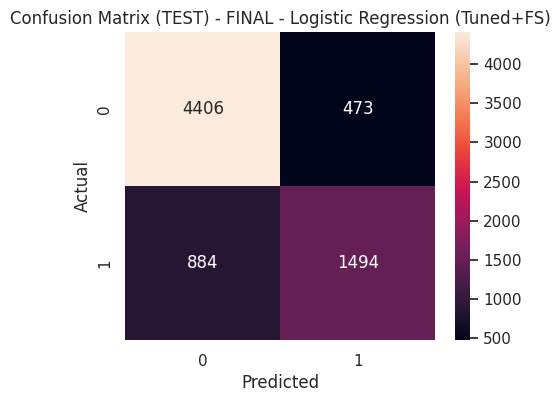


FINAL - Random Forest (Tuned+FS) - TRAIN METRICS
Accuracy : 0.9941435855036517
Precision: 0.9943897533608553
Recall   : 0.9876984544211965
F1-Score : 0.9910328093680768

FINAL - Random Forest (Tuned+FS) - TEST METRICS
Accuracy : 0.9076753479399201
Precision: 0.8924632352941176
Recall   : 0.8166526492851135
F1-Score : 0.8528765920070268

Classification Report (TEST):
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      4879
           1       0.89      0.82      0.85      2378

    accuracy                           0.91      7257
   macro avg       0.90      0.88      0.89      7257
weighted avg       0.91      0.91      0.91      7257



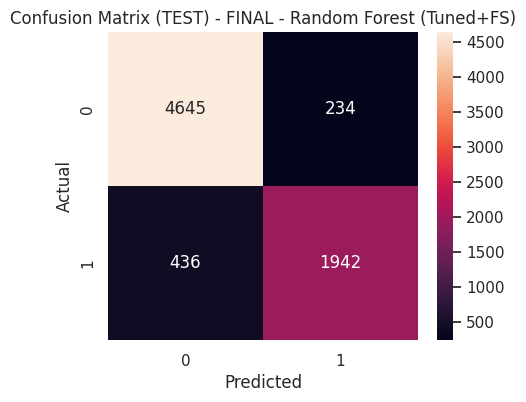

,Model,CV Score (F1),Accuracy,Precision,Recall,F1-Score
0,Model A: Logistic Regression (Tuned + FS),0.675320,0.813008,0.759532,0.628259,0.687687
1,Model B: Random Forest (Tuned + FS),0.840153,0.907675,0.892463,0.816653,0.852877



BEST FINAL MODEL (by TEST F1): Model B: Random Forest (Tuned + FS)


In [ ]:
# TASK 6: FINAL MODELS + COMPARATIVE ANALYSIS (TABLE)

final_logreg = logreg_fs_pipe
final_rf = rf_fs_pipe

eval_classification(final_logreg, X_train, y_train, X_test, y_test, name="FINAL - Logistic Regression (Tuned+FS)")
eval_classification(final_rf, X_train, y_train, X_test, y_test, name="FINAL - Random Forest (Tuned+FS)")

def metrics_row(model, X_te, y_te, cv_score, model_name):
    yhat = model.predict(X_te)
    return {
        "Model": model_name,
        "CV Score (F1)": cv_score,
        "Accuracy": accuracy_score(y_te, yhat),
        "Precision": precision_score(y_te, yhat, zero_division=0),
        "Recall": recall_score(y_te, yhat, zero_division=0),
        "F1-Score": f1_score(y_te, yhat, zero_division=0),
    }

final_table = pd.DataFrame([
    metrics_row(final_logreg, X_test, y_test, logreg_grid.best_score_, "Model A: Logistic Regression (Tuned + FS)"),
    metrics_row(final_rf, X_test, y_test, rf_grid.best_score_, "Model B: Random Forest (Tuned + FS)")
])

display(final_table)

best_idx = final_table["F1-Score"].idxmax()
print("\nBEST FINAL MODEL (by TEST F1):", final_table.loc[best_idx, "Model"])

